# BE/Bi 103, Fall 2016: Homework 3
## Due 1pm, Sunday, October 16

(c) 2016 Justin Bois. With the exception of the images, this work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained therein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw3.ipynb).*

In [48]:
import numpy as np
import pandas as pd
import scipy.optimize
import statsmodels.tools.numdiff as smnd

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Some pretty Seaborn settings
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# Make Matplotlib plots appear inline
%matplotlib inline

### Problem 3.1: Dorsal gradients in *Drosophila* embryos (60 pts)
We will use a data set from [Angela Stathopoulos's lab](http://www.stathlab.caltech.edu), acquired to study morphogen profiles in developing fruit fly embryos.  The original paper is [Reeves, Trisnadi, et al., Dorsal-ventral gene expression
in the *Drosophila* embryo reflects the dynamics and precision of the Dorsal nuclear gradient, *Dev. Cell.*, **22**, 544-557, 2012](http://bebi103.caltech.edu/2015/protected/papers/reeves_2012.pdf), and the data set may be downloaded [here](protected/data/reeves_dv_profile_over_time.csv) and [here](protected/data/reeves_gradient_width_various_methods.csv)

In this experiment, Reeves, Trisnadi, and coworkers measured expression levels of a fusion of Dorsal, a morphogen transcription factor important in determining the dorsal-ventral axis of the developing organism, and Venus, a yellow fluorescent protein along the dorsal/ventral- (DV) coordinate.  They put this construct on the third chromosome, while the wild type *dorsal* is on the second.  Instead of the wild type, they had a homozygous *dorsal*-null mutant on the second chromosome.  The Dorsal-Venus construct rescues wild type behavior, so they could use this construct to study Dorsal gradients.

Dorsal shows higher expression on the ventral side of the organism, thus giving a *gradient* in expression from dorsal to ventral which can be ascertained by the spatial distribution of Venus fluorescence intensity.

This can be seen in the image below, which is a cross section of a fixed embryo with anti-Dorsal staining.  The bottom of the image is the ventral side and the top is the dorsal side of the embryo.  The DV coordinate system is defined by the yellow line.  It is periodic, going from $-1$ to $1$.  The DV-coordinate is therefore defined in relative terms around the embryo and is dimensionless.  The ventral nuclei show much higher expression of Dorsal.  The image is adapted from the Reeves, Trisnadi, et al. paper.

<img src="DV_coord.png">

*A quick note on nomenclature:* Dorsal (capital D) is the name of the protein product of the gene *dorsal* (italicized).  The dorsal (adjective) side of the embryo is its back.  The ventral side is its belly.  Dorsal is expressed more strongly on the ventral side of the developing embryo.  This can be confusing.

To quantify the gradient, Reeves, Trisnadi, and coworkers had to first choose a metric for describing it.  They chose to fit the measured profile of fluorescence intensity with a Gaussian (plus background) and use the standard deviation of that Gaussian as a metric for the width of the Dorsal gradient.  This provides a nice motivation for doing nonlinear regression.

It is important not to confuse ourselves here. We are not implying that the fluorescent intensity is somehow Gaussian distributed in space. It is merely peaked, and the functional form of a Gaussian is a convenient way to describe the peak.

The file [`reeves_dv_profile_over_time.csv`](protected/data/reeves_dv_profile_over_time.csv) contains the measured level of fluorescence intensity coming from the Dorsal-Venus construct at different stages of development.  Timing of development in the *Drosophila* embryo based on *nuclear cycles*, the number of nuclear divisions that have happened since fertilization.  Prior to cellularization of the syncytium, there are 14 rounds of nuclear division.  Reeves, Trisnadi, et al. measured Dorsal-Venus expression at nuclear cycle 11, 12, 13, and 14.

**a)** Comment on the choice of a Gaussian-plus-background function to fit the data.  Why do you think this was chosen?  Do you have other suggestions?

**b)** Write down expressions for the likelihood, prior, and posterior for a regression of this sort of data.  Be sure to explicitly state which assumptions go into these choices.

**c)** Perform regressions by optimization to quantify the width of the Dorsal-Venus gradient at each nuclear cycle.  Be sure to report error bars on the parameters you obtain.  You should also plot the gradient corresponding to the most probable parameter values along with the experimentally observed data points.

**d)** Reeves performed regressions like you have just done on many samples, including different methods of imaging.  These data are contained in the file `reeves_gradient_width_various_methods.csv`.  Be sure to read the comments describing the data.  Generate a plot summarizing these data.  Discuss your choice for how you chose to render your plot.  Based on what you see, is the Venus fusion a reasonable way to study the Dorsal gradient, as compared to the wild type cross-section gold standard?

### Problem 3.1: solution

**a)** To perform the regression, we of course need to know what model function to fit.  Reeves, et al. proposed using a Gaussian curve, plus background, to describe the profiles. They likely chose this because it is a well-known function with a single peak, and the width of the peak is parametrized by a familiar parameter: the standard deviation $\sigma$. These considerations make it a good choice for fitting the Dorsal profile.

Strictly speaking, a Gaussian is not periodic, and these data are periodic, so we should fit a periodic function.  The periodic version of the Gaussian distribution is a Von Mises distribution,

\begin{align}
P(\theta~|~\mu,\beta) = \frac{\mathrm{e}^{\beta\cos(\theta - \mu)}}{2\pi I_0(\beta)},
\end{align}

where $\theta \in (0,2\pi]$ and $I_0(s)$ is a modified Bessel function.  The parameter $\beta$ is analogous to $1/\sigma^2$ in a Gaussian, and $\mu$ is of course analogous to $\mu$.  To use the Von Mises distribution to fit these data, we would make the change of variables $x = \theta/\pi - 1$ (where $x$ is the DV coordinate) giving

\begin{align}
P(x~|~\mu,\beta) = \frac{\mathrm{e}^{\beta\cos(\pi(x - \mu))}}{2 I_0(\beta)}.
\end{align}

However, because the Gaussian decays away far before the dorsal side, a Gaussian is for all practical purposes periodic, so we should be ok using it. So, we will follow the paper and use a Gaussian plus background to fit the data.  (Note: the authors were aware of the periodicity issue and commented on it in their paper; they were being careful!)  The standard deviation can then be a metric for gradient width.  The equation is

\begin{align}
F(x; a, b, \mu, \sigma) = a + b \exp\left\{-\frac{(x - \mu)^2}{2\sigma^2}\right\},
\end{align}

where $a$ is the background, $b$ sets the arbitrary scale of the $y$-axis, $\mu$ is the location of the center of the peak, and $\sigma$ describes the width of the peak.  We use $F$ to stand for fluorescence intensity.

**b)** In our regression, we will assume that each nucleus has a fluorescence intensity that is drawn from a process that gives Gaussian distributed intensities in accordance the central limit theorem.  So as not to confuse notation, we will call the (unknown) variance of this process $\sigma_F$ (we usually call it $\sigma$).

We will also assume that the parameters $a$ and $b$ are not the same from one experiment to another, possibly due to different levels of photobleaching prior to each experiment.

With all this in hand, we can write our likelihood.

\begin{align}
P(D\mid a, b, \mu, \sigma,\sigma_I, I) &= \prod_{i\in D}\frac{1}{\sqrt{2\pi\sigma_F^2}}\,
\exp\left\{-\frac{\left(F_i - F(x_i;a,b,\mu,\sigma)\right)^2}{2\sigma_F^2}\right\} \\
&= \prod_{i\in D}\frac{1}{\sqrt{2\pi\sigma_F^2}}\,
\exp\left\{-\frac{1}{2\sigma_F^2}\left(F_i - a - b \,\mathrm{e}^{-(x_i - \mu)^2/2\sigma^2}\right)^2\right\}
\end{align}

We will assume the five parameters are independent, so the prior is the product of their respective priors.  As usual, we will assume a Jeffreys prior on $\sigma_F$.  We will assume a uniform prior on $\mu$, noting that $-1 < \mu \le 1$.  We will also assume uniform priors on $a$ and $b$, noting that $a,b > 0$.  Finally, we will assume a uniform prior on $\sigma$.  Why not a Jeffreys prior?  A Jeffreys prior is not necessarily inappropriate, but because we are on a finite domain and $\sigma$ is describing a well-defined width of a gradient, we do not wish to enforce symmetry property of $P(\sigma < 1 \mid I) = P(\sigma > 1 \mid I)$, which is where the Jeffreys prior comes from.

We can now write the posterior.

\begin{align}
P(a,b,\mu,\sigma,\sigma_F) \propto \sigma_F^{-n-1} \,\exp\left\{-\frac{1}{2\sigma_F^2}\sum_{i\in D} \left(F_i - a - b \,\mathrm{e}^{-(x_i - \mu)^2/2\sigma^2}\right)^2\right\}.
\end{align}

We marginalize over $\sigma_F$ to get a Student-t distribution, as we have seen a few times now.

\begin{align}
P(a,b,\mu,\sigma) \propto \left(\sum_{i\in D} \left(F_i - a - b \,\mathrm{e}^{-(x_i - \mu)^2/2\sigma^2}\right)^2\right)^{-n/2}.
\end{align}

**c)** First, we'll load and tidy the data set.

In [49]:
# Load the nuclear Venus fluorescence intensity levels into a DataFrame
df = pd.read_csv('../data/reeves_dv_profile_over_time.csv',
                 comment='#')

# Take a look
df.head()

,DV coord nc 14,fluor intensity nc 14,DV coord nc 13,fluor intensity nc 13,DV coord nc 12,fluor intensity nc 12,DV coord nc 11,fluor intensity nc 11
0,0.7813,1.6512,0.7939,1.6763,0.9210,1.0523,0.9347,1.2730
1,0.8565,1.4200,0.8404,1.1663,-0.5801,1.4345,-0.9663,1.1778
2,0.8986,1.3845,0.8789,1.3919,-0.5192,1.2087,-0.5628,1.2967
3,0.9286,1.3960,0.9879,1.2993,-0.4795,1.2272,-0.3528,1.4155
4,-0.9356,1.1741,-0.9231,1.2076,-0.3491,1.4272,-0.1478,2.0224


We'll create a `MultiIndex` for the column headings and then melt the `DataFrame`.

In [50]:
# Make MultiIndex, level_0 is nuclear cycle, level_1 is DV coor or fluor int.
level_0 = [int(col[-2:]) for col in df.columns]
level_1 = [col[:col.find(' nc')] for col in df.columns]
df.columns = pd.MultiIndex.from_tuples(list(zip(level_0, level_1)),
                                       names=['nuclear cycle', 'variable'])

# Make tidy df
df_tidy = pd.DataFrame(columns=['nuclear cycle', 'DV coord', 'fluor intensity'])
for nuc_cycle in df.columns.get_level_values('nuclear cycle'):
    df_add = df[nuc_cycle].dropna()
    df_add['nuclear cycle'] = pd.Series([nuc_cycle] * len(df_add),
                                        index=df_add.index)
    df_tidy = df_tidy.append(df_add, ignore_index=True)
    
# Make sure nuclear cycle is int
df_tidy['nuclear cycle'] = df_tidy['nuclear cycle'].astype(int)

# Take a look
df_tidy.head()

variable,DV coord,fluor intensity,nuclear cycle
0,0.7813,1.6512,14
1,0.8565,1.4200,14
2,0.8986,1.3845,14
3,0.9286,1.3960,14
4,-0.9356,1.1741,14


This is a convenient form of a tidy `DataFrame` because we can get, e.g., the DV coordinates got nuclear cycle 14 out of it as

    df_tidy.loc[df_tidy['nuclear cycle']==14, 'DV coord']
    
Conversely, we could have just melted the whole thing.

In [51]:
df_melt = pd.melt(df)
df_melt.head()

,nuclear cycle,variable,value
0,14,DV coord,0.7813
1,14,DV coord,0.8565
2,14,DV coord,0.8986
3,14,DV coord,0.9286
4,14,DV coord,-0.9356


To pull out the DV coordinate for nuclear cycle 14 in this `DataFrame`, we could do

    inds = (df_melt['nuclear cycle'] == 14) \
                           & (df_melt['variable'] == 'DV coord')
    df_melt.loc[inds, 'value']
    
Either type of tidy `DataFrame` is fine. We will use the first one, `df_tidy` going forward.

Now, since we will perform many regressions, I will write a few functions to perform the regressions.

In [52]:
def peak(p, x):
    """
    Theroetical peak (Gaussian + bg)
    """
    a, b, mu, sigma = p
    return a + b * np.exp(-(x - mu)**2 / 2 / sigma**2)


def resid(p, x, f):
    """
    Residuals for peak fitting.
    """
    return f - peak(p, x)


def log_post(p, x, f):
    """
    (Unnormalized) log of the posterior.
    """
    return -len(x) / 2 * np.log(np.sum(resid(p, x, f)**2))


def covariance(popt, x, f):
    """
    Compute covariance matrix at popt.
    """
    hes = smnd.approx_hess(popt, log_post, args=(x, f))
    return -np.linalg.inv(hes)
  
    
def fit_model(df, nuc_cycle, print_results=False):
    """
    Perform regression on nuclear cycle.
    """
    # Extract data
    inds = df['nuclear cycle'] == nuc_cycle
    x = df.loc[inds, 'DV coord'].values
    f = df.loc[inds, 'fluor intensity'].values
    
    # Initial guess
    a = 1.0
    b = 5.0
    mu = 0.0
    sigma = 0.5
    p0 = np.array([a, b, mu, sigma])
    
    # Get most probable parameter values
    args = (x, f)
    popt, _= scipy.optimize.leastsq(resid, p0, args=args)

    # Get covariance matrix
    cov = covariance(popt, x, f)
    
    # Compute errors
    a_err, b_err, mu_err, sigma_err = np.sqrt(np.diag(cov))

    # Report results
    if print_results:
        print("""\n\nMost probable parameter values for nuclear cycle {8:d}:
        a =     {0:.3f} += {4:.3f}
        b =     {1:.3f} += {5:.3f}
        mu =    {2:.3f} += {6:.3f}
        sigma = {3:.3f} += {7:.3f}""".format(
                        popt[0], popt[1], popt[2], popt[3], 
                        a_err, b_err, mu_err, sigma_err, nuc_cycle))
    
    # Return optimizal parameters and covariance matrix
    return popt, cov


def fit_all_models(df, print_results=False):
    """
    Find widths of all nuclear cycles.
    """
    results = {}
    for nuc_cycle in sorted(df_tidy['nuclear cycle'].unique()):
        popt, cov = fit_model(df_tidy, nuc_cycle, print_results=print_results)
        results[nuc_cycle] = {'popt': popt, 'cov': cov}
    
    return results

Now, we'll fit each data set and determine the Dorsal gradient widths.

In [54]:
fit_results = fit_all_models(df_tidy, print_results=True)



Most probable parameter values for nuclear cycle 11:
        a =     1.324 += 0.037
        b =     1.505 += 0.090
        mu =    0.011 += 0.008
        sigma = 0.149 += 0.013


Most probable parameter values for nuclear cycle 12:
        a =     1.247 += 0.069
        b =     2.828 += 0.139
        mu =    -0.000 += 0.007
        sigma = 0.152 += 0.010


Most probable parameter values for nuclear cycle 13:
        a =     1.280 += 0.027
        b =     3.249 += 0.057
        mu =    -0.003 += 0.003
        sigma = 0.158 += 0.004


Most probable parameter values for nuclear cycle 14:
        a =     1.243 += 0.033
        b =     4.297 += 0.078
        mu =    -0.011 += 0.003
        sigma = 0.162 += 0.004


We can now plot the most probable curves along with the data.

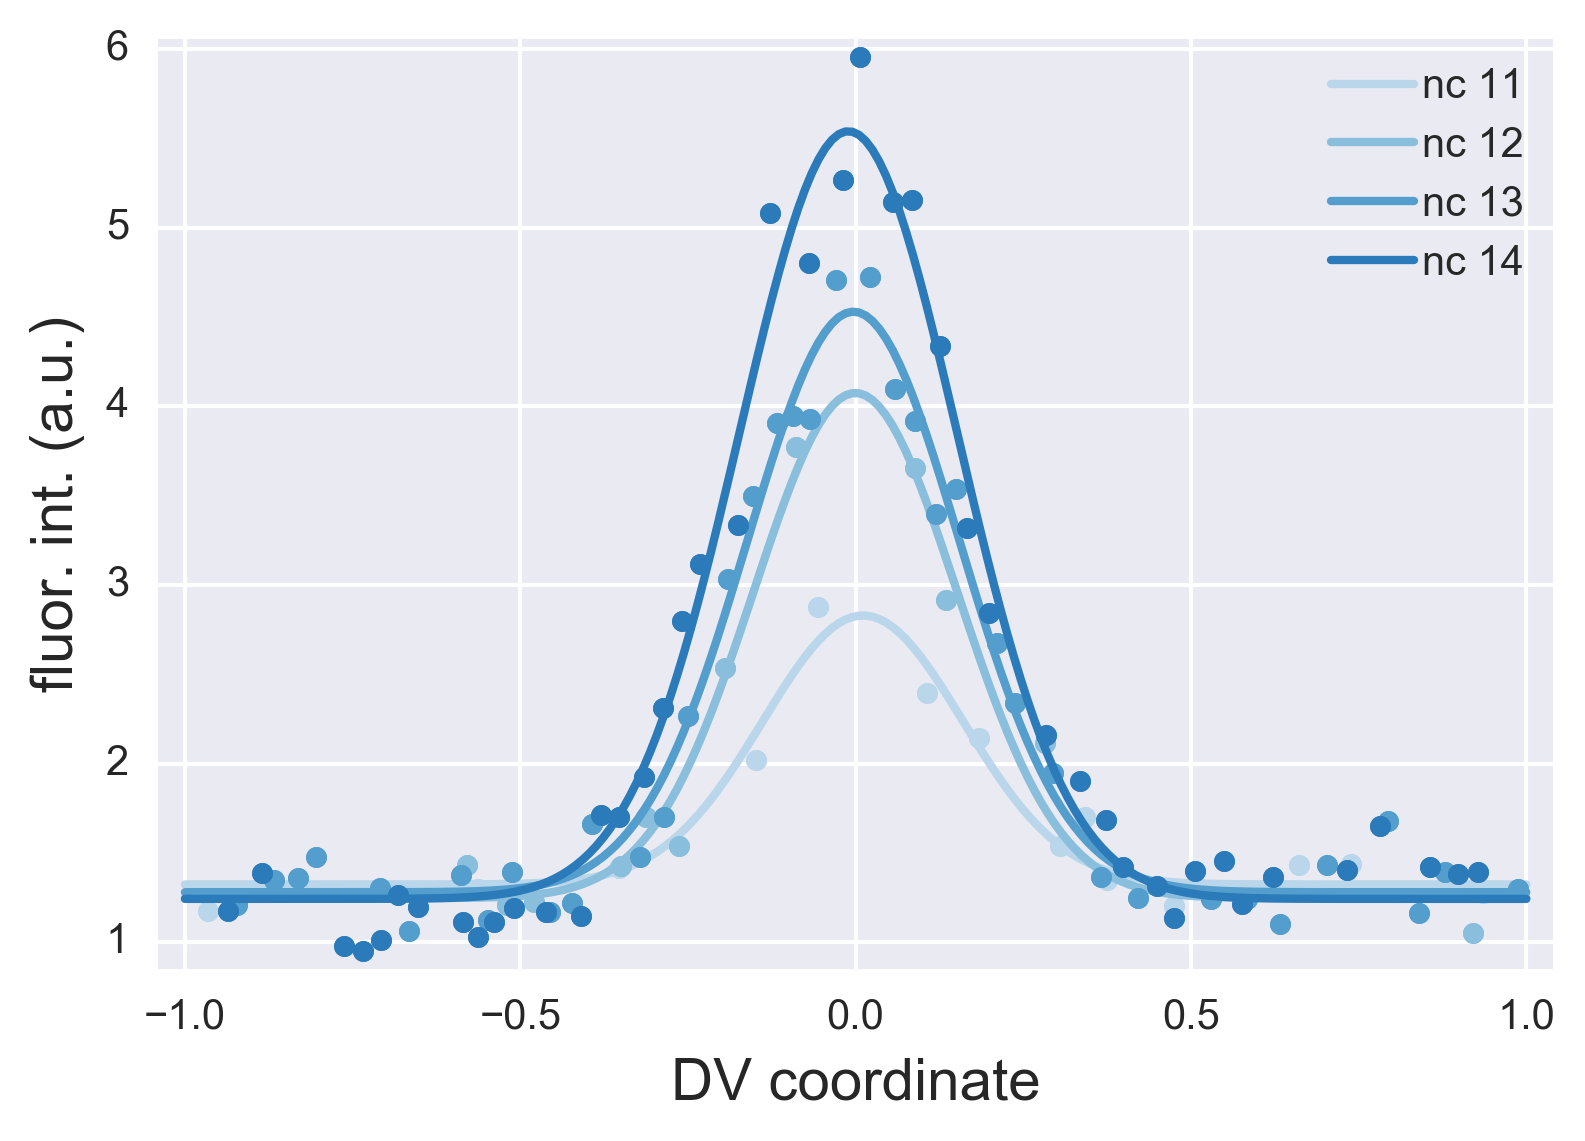

In [58]:
# Smooth curve x
x_smooth = np.linspace(-1, 1, 200)

# Colors for plot
colors = sns.color_palette('Blues', 6)[1:-1]

# Generate plot for each nuclear cycle
for i, nuc_cycle in enumerate(sorted(df_tidy['nuclear cycle'].unique())):
    # Label
    label = 'nc ' + str(nuc_cycle)

    # Plot smooth curve
    plt.plot(x_smooth, peak(fit_results[nuc_cycle]['popt'], x_smooth), '-', 
             color=colors[i], label=label)
    
    # Generate plot of points
    inds = df_tidy['nuclear cycle'] == nuc_cycle
    x = df_tidy.loc[inds, 'DV coord'].values
    f = df_tidy.loc[inds, 'fluor intensity'].values
    plt.plot(x, f, '.', markersize=10, color=colors[i])
    
# Label axes
plt.xlabel('DV coordinate')
plt.ylabel('fluor. int. (a.u.)')

# Nice margins
plt.margins(0.02)
    
# Add legend
plt.legend();

The location of the peak is similar in all traces, and the width of the gradient seems to grow slightly over time. We can plot it to see how strong the effect is.

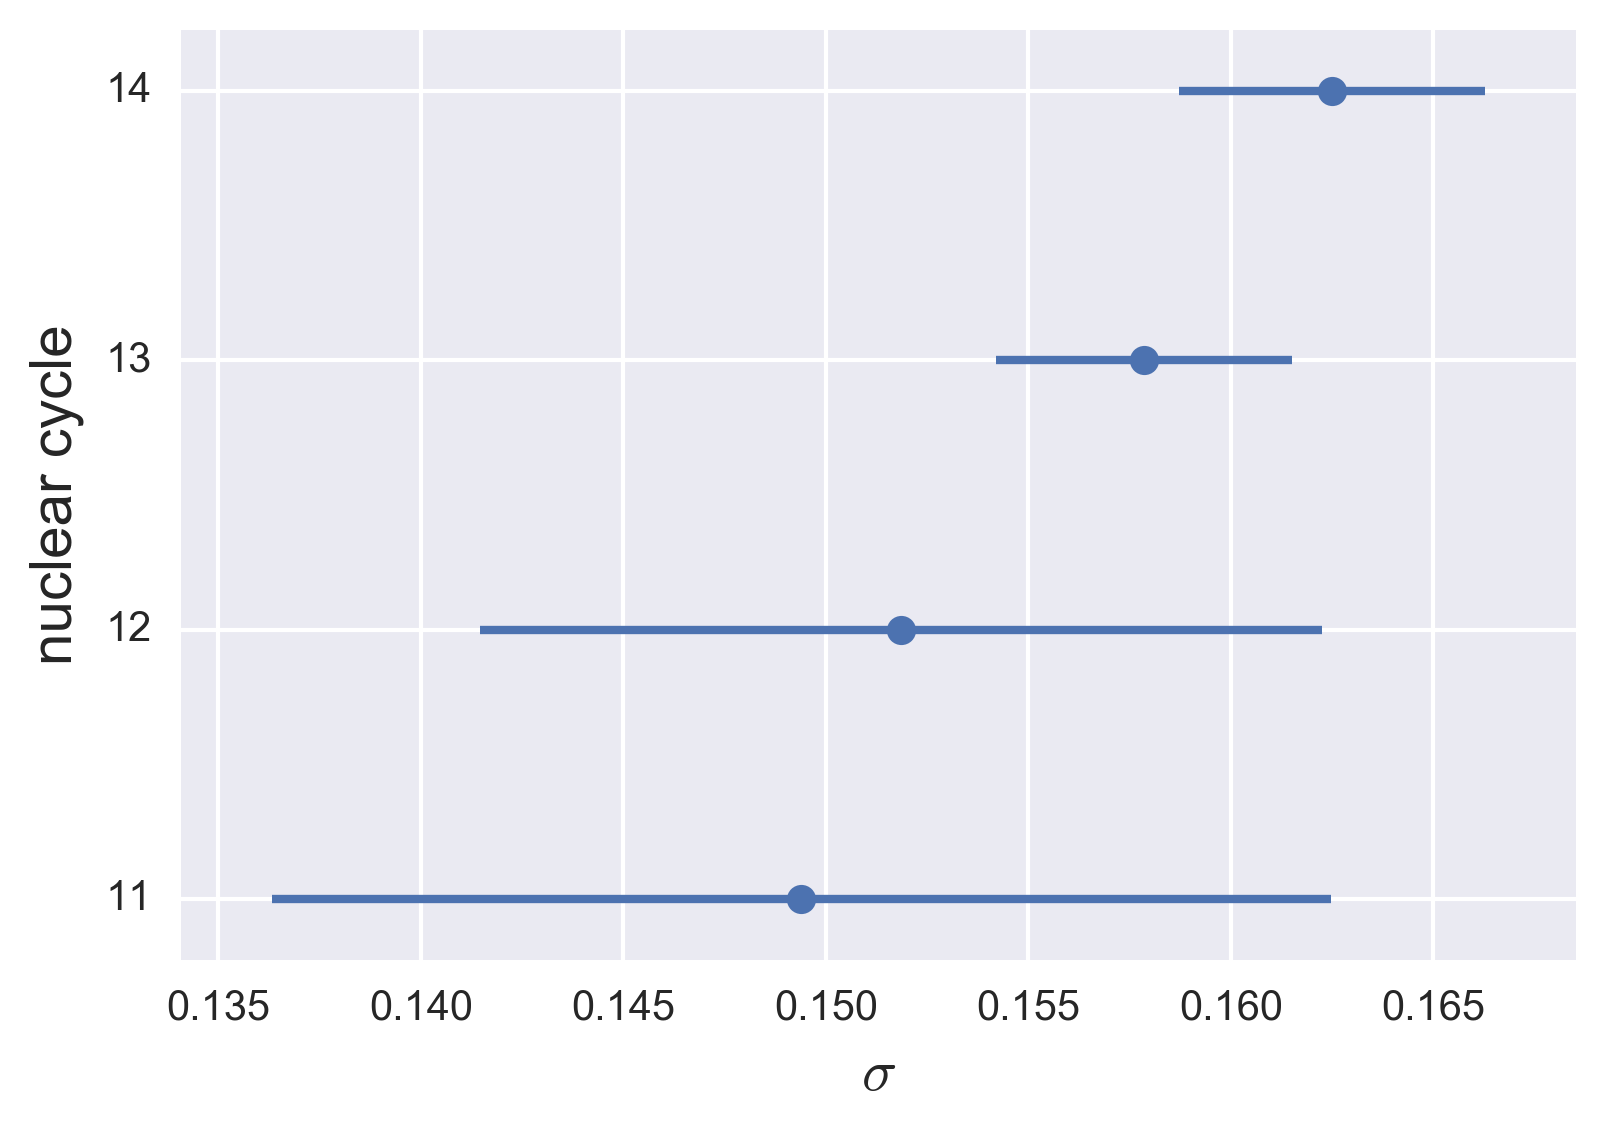

In [61]:
# Plot each gradient width with error bar
for nuc_cycle in df_tidy['nuclear cycle'].unique():
    plt.errorbar(fit_results[nuc_cycle]['popt'][-1], nuc_cycle,
                 xerr=np.sqrt(fit_results[nuc_cycle]['cov'][-1,-1]), marker='o', 
                 color=sns.color_palette()[0])

# Clean up plot
plt.margins(0.075)
plt.ylabel('nuclear cycle')
plt.xlabel(r'$\sigma$')
plt.yticks(list(sorted(df_tidy['nuclear cycle'].unique())));

So, the effect is not strong compared to the error in determination of the gradient width $\sigma$.

**d)** We usually like to start with a beeswarm plot, so let's start with that.  This is easily accomplished using Seaborn with a tidy `DataFrame`. So, we first need to tidy the `DataFrame`.

In [95]:
# Load data into DataFrame
file_name = '../data/reeves_gradient_width_various_methods.csv'
df = pd.read_csv(file_name, comment='#', header=[0, 1])

# Tidy the DataFrame
df = pd.melt(df, var_name=['genotype', 'method'], value_name='width').dropna()
df.head()

,genotype,method,width
0,wt,wholemounts,0.1288
1,wt,wholemounts,0.1554
2,wt,wholemounts,0.1306
3,wt,wholemounts,0.1413
4,wt,wholemounts,0.1557


With our nice, tidy `DataFrame`, we can make our beeswarm plot.

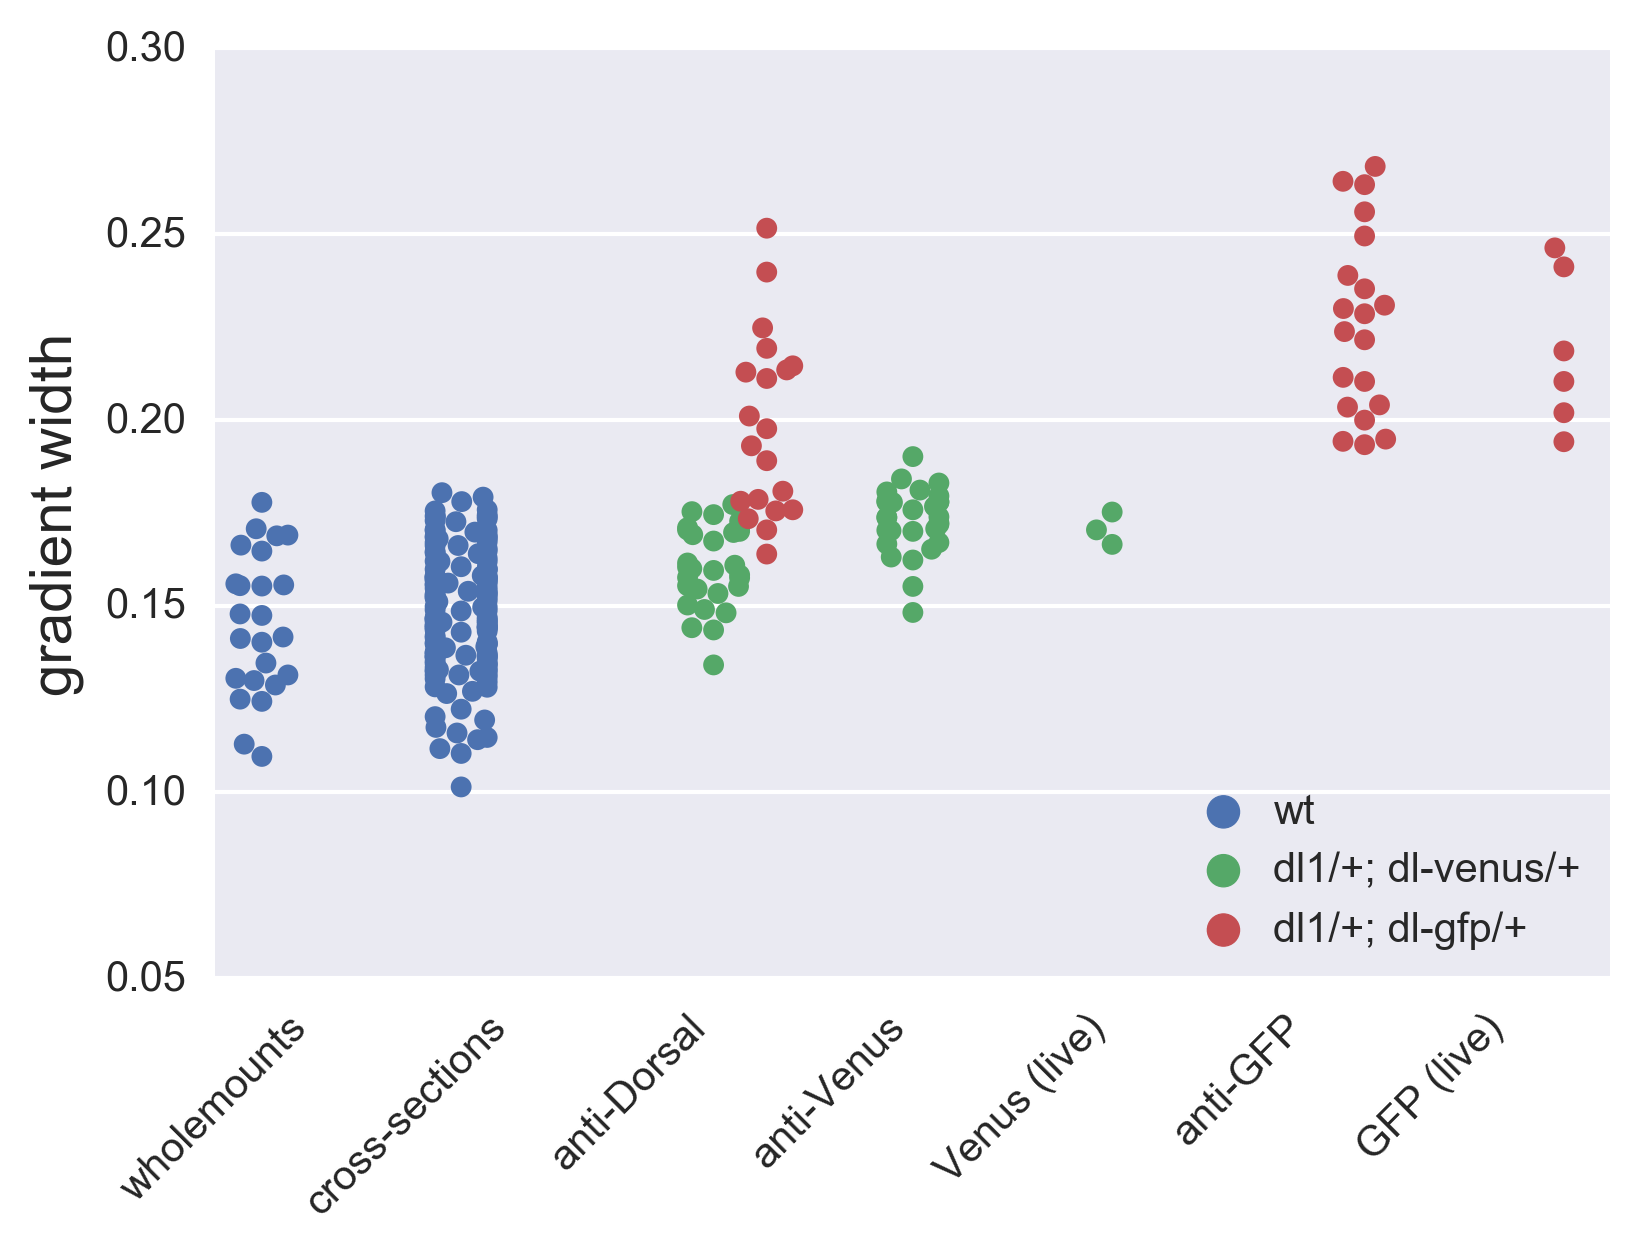

In [97]:
# Generate swarm plot
sns.swarmplot(data=df, x='method', y='width', hue='genotype', split=True)

# Tilt axis labels
plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=45, 
         horizontalalignment='right');

# Set legend location
plt.legend(loc='lower right')

# Relabel axes
plt.ylabel('gradient width')
plt.xlabel('');

There is a problem with the beeswarm plot. There were so many measurements by cross-section that the points in the beeswarm plot overlap. Nonetheless, it is clear from this plot that the GFP mutants have substantially bigger Dorsal gradients than their wild type or Venus analogs.

Let's instead try a jitter plot.

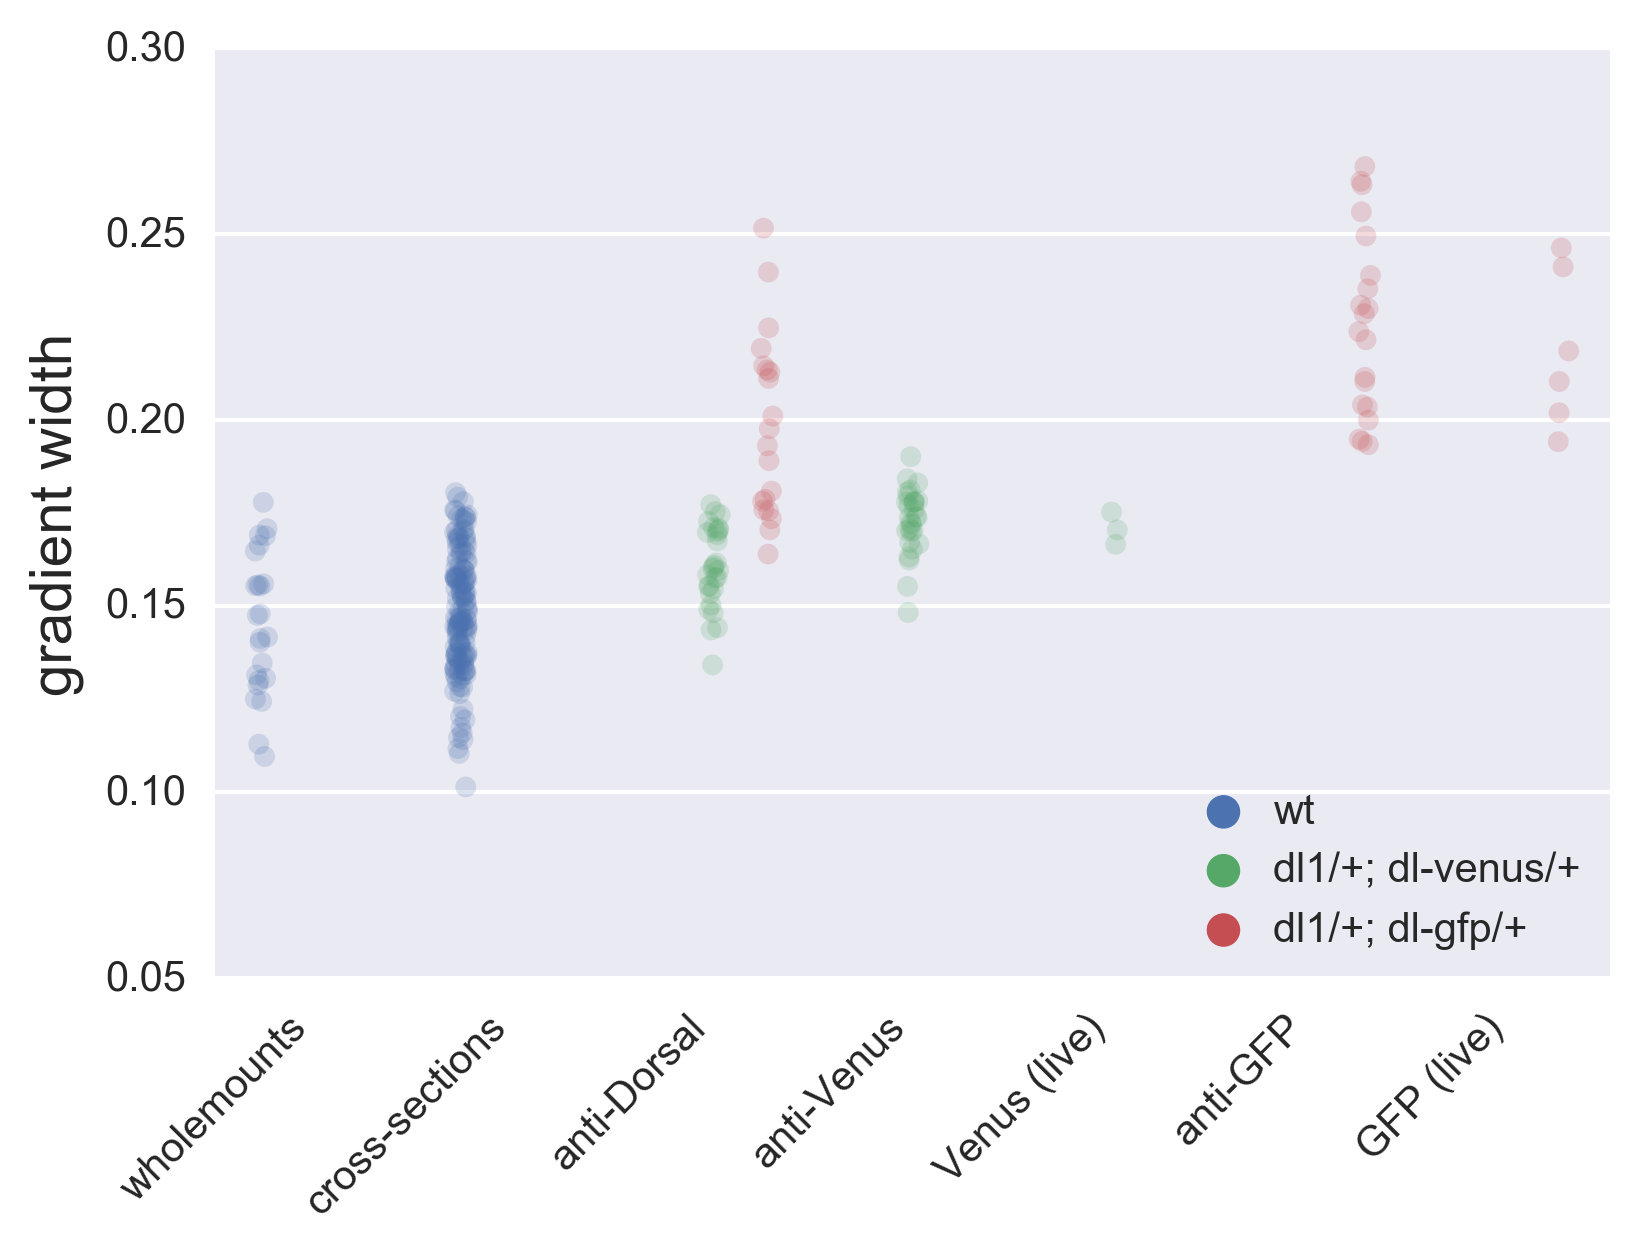

In [101]:
# Generate swarm plot
sns.stripplot(data=df, x='method', y='width', hue='genotype', split=True, 
              jitter=True, alpha=0.2, edgecolor='white')

# Tilt axis labels
plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=45, 
         horizontalalignment='right');

# Set legend location
plt.legend(loc='lower right')

# Relabel axes
plt.ylabel('gradient width')
plt.xlabel('');

This is a bit better. Let's overlay box plots.

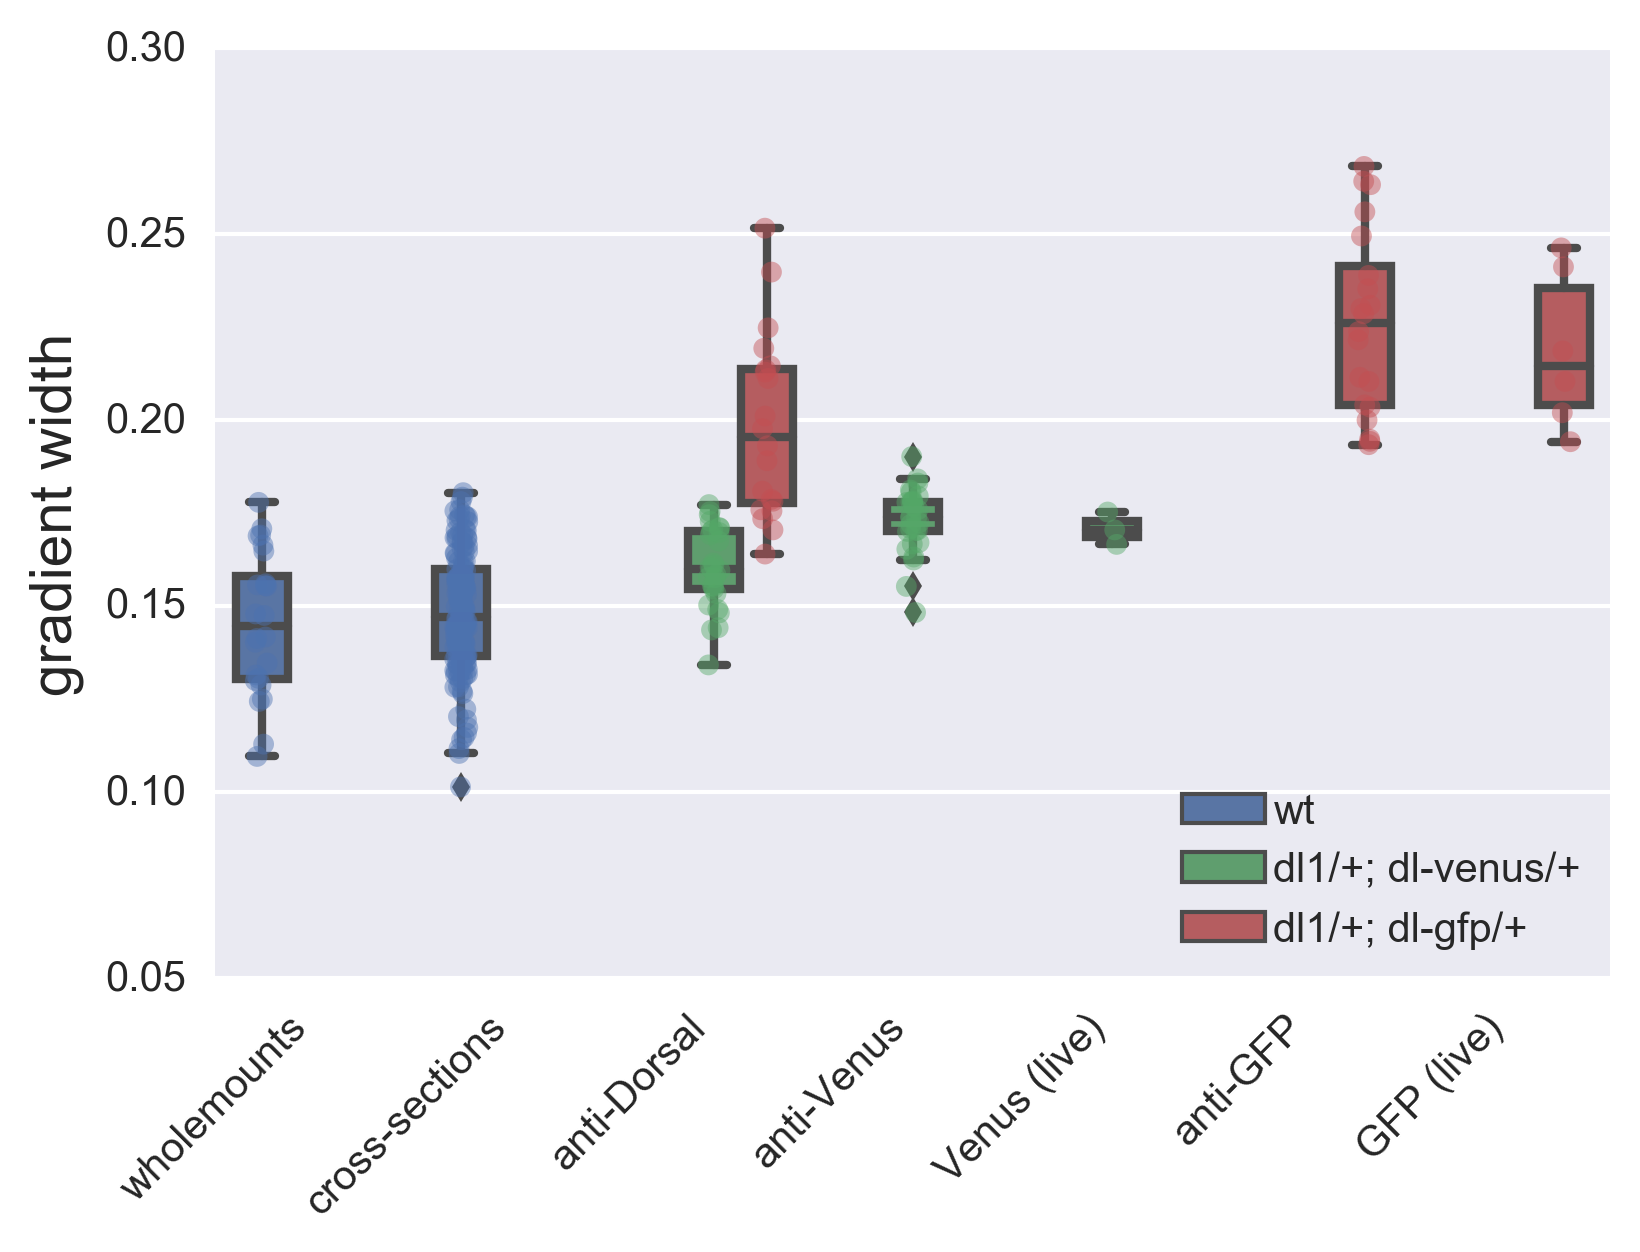

In [111]:
# Generate plots
fig, ax = plt.subplots(1, 1)
sns.boxplot(data=df, x='method', y='width', hue='genotype', ax=ax)
sns.stripplot(data=df, x='method', y='width', hue='genotype', split=True, 
              jitter=True, alpha=0.45, edgecolor='white', ax=ax)

# Tilt axis labels
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, 
         horizontalalignment='right')

# Clean up legend
handles, labels = ax.get_legend_handles_labels()
_ = plt.legend(handles[0:3], labels[0:3], loc='lower right')

# Relabel axes
plt.ylabel('gradient width')
plt.xlabel('');

The Venus samples have gradient widths that are consistently higher than the average of the wild type mounts.  Nonetheless, they all fall within the higher range of gradient widths that we see with wild type mounts.  The GFP samples, however, show consistently higher gradient widths.  They do not rescue the *dorsal* deficiency, so that are not very useful anyhow.

<br />

### Problem 3.2: HIV clearance and a warning about regressions (30 pts)

A human immunodeficiency virus (HIV) is a virus that causes host organisms to develop a weaker, and sometimes ineffective, immune system. HIV inserts its viral RNA into a target cell of the immune system.  This virus gets reverse transcribed into DNA and integrated into the host cell's chromosomes.  The host cell will then transcribe the integrated DNA into mRNA for the production of viral proteins and produce new HIV.  Newly created viruses then exit the cell by budding off from the host.  HIV carries the danger of ongoing replication and cell infection without termination or immunological control.  Because CD4 T cells, which communicate with other immune cells to activate responses to foreign pathogens, are the targets for viral infection and production, their infection leads to reductions in healthy CD4 T cell production, causing the immune system to weaken.  This reduction in the immune response becomes particularly concerning after remaining infected for longer periods of time, leading to acquired immune deficiency syndrome (AIDS).

Perelson and coworkers have developed mathematical models to study HIV populations in the eukaryotic organisms.  HIV-1 infects cells at a rate $k$ and is produced from these infected T cells at a rate $p$.  On the other hand, the viruses are lost due to clearance by the immune system of drugs, which occurs at a rate $c$, and infected cells die at a rate $\delta$ (Figure from [Perelson, *Nat. Rev. Immunol.*, **2**, 28-36, 2002](../protected/papers/perel_son2002.pdf))

![/Basic model of viral infection](hiv_figure.jpg "Basic model of viral infection Perelson Nat. Rev. Immunol. 2002)")

The above process can be written down as a system of differential equations.

\begin{align}
\frac{dT^*}{dt} &= k V_I T - \delta T^*\\[1em]
\frac{dV_I}{dt} &= -cV_I\\[1em]
\frac{dV_{NI}}{dt} &= N \delta T^{*} - c V_{NI},
\end{align}

Here, $T(t)$ is the number of uninfected T-cells at time $t$, and $T^*$ is the number of infected T cells. Furthermore, there is a concentration $V_I(t)$ of infectious viruses that infect T cells at the rate $k$.  We also have a concentration $V_{NI}$ of innocuous viruses. We define $N(t)$ to be the number of newly produced viruses from one infected cell over this cell's lifetime.  We can measure the total viral load, $V(t) = V_I(t) + V_{NI}(t)$.  If we initially have a viral load of $V(0) = V_0$, we can solve the system of differential equations to give

\begin{align}
V(t) = V_0e^{-ct} + \frac{cV_0}{c-\delta}\left[\frac{c}{c-\delta}(e^{-{\delta}t} - e^{-ct}) - {\delta}te^{-ct}\right].
\end{align}

We will take viral load data from a real patient (which you can download [here](data/hiv_data.csv)) and perform a regression to evaluate the parameters $c$ and $\delta$.  The patient was treated with the drug Ritonavir, a protease inhibitor that serves to clear the viruses; i.e., it modulates $c$. So, in the context of the model, $c$ is a good parameter to use to understand the efficacy of a drug.

**a)** Perform a regression on these data using the theoretical temporal curve for the viral load. That is, obtain estimates for $V_0$, $c$, and $\delta$ but finding the MAP and computing error bars.

**b)** Plot the posterior distribution over the interval $0 \le \delta, c \le 10$ days$^{-1}$.  Does this plot raise any serious issues about how you estimate $c$ and $d$?  What experiments might you propose to help deal with these problems? *Hint*: In order to compute the marginalized posterior,

\begin{align}
P(c, \delta \mid D, I) = \int_0^\infty \mathrm{d}V_0 P(c, \delta, V_0 \mid D, I),
\end{align}

you can perform numerical quadrature using functions like `np.trapz()`. If you are having trouble doing that, make a plot of $P(c, \delta, V_0 \mid D, I)$ in the $c$-$\delta$ plane with $V_0$ fixed at its most probable value.

<br />

### Problem 3.3: Error propagation (10 pts)

Often times, our colleagues do not provide us with full data sets in papers. Say you read two papers, each measuring the same property under putatively the same conditions. One paper reports an estimate of a parameter $\mu$ as $\mu_1 \pm \sigma_1$ and the other reports a value of $\mu_2 \pm \sigma_2$. Based only on this information, what is the most probable value of $\mu$, and what is its error bar?

<br />

### Problem 3.4: Checking model assumptions (20 pts extra credit)

In [Tutorial 3a](tutorials/t3a_parameter_estimation_by_optimization.html), we did a check on some of the model assumptions, in particular that  $Vs/V_0 \ll 1$ and that the aspect ratio $k$ is the same for all spindles. Based on the analysis in that tutorial, are you concerned that a nonconstant $k$ might affect your analysis? Implement a remedy for the potential effects. As a reminder, the data set may be downloaded [here](data/good_invitro_droplet_data.csv).